In [37]:
import pickle
import pandas as pd

# Load
# "data/biomass_sample_data.pkl"
with open("data/biomass_sample_data_reps_separate.pkl", "rb") as f:
    df_loaded = pickle.load(f)

df_loaded.head()

,days_of_phenotyping,species,nitrogen_applied,drought_stress,rep,mean_plant_temperature,median_plant_temperature,std_plant_temperature,min_plant_temperature,max_plant_temperature,mean_side_area,mean_top_area,digital_biomass
0,1,barley_1,25,0,1,24.447787,24.424066,0.902963,21.906194,27.958105,29357.909527,35079.04116,5.498560e+06
1,2,barley_1,25,0,1,24.451300,24.475998,0.958762,21.744783,27.867776,29545.947366,35168.96481,5.540867e+06
2,3,barley_1,25,0,1,24.532748,24.573843,0.989323,21.557134,27.984342,29512.180481,37351.67743,5.703696e+06
3,4,barley_1,25,0,1,24.434585,24.451585,0.945582,21.674772,27.894140,29254.245671,38200.53196,5.717730e+06
4,5,barley_1,25,0,1,24.432615,24.442659,0.945267,21.747331,28.126928,28722.438850,39499.22940,5.708416e+06


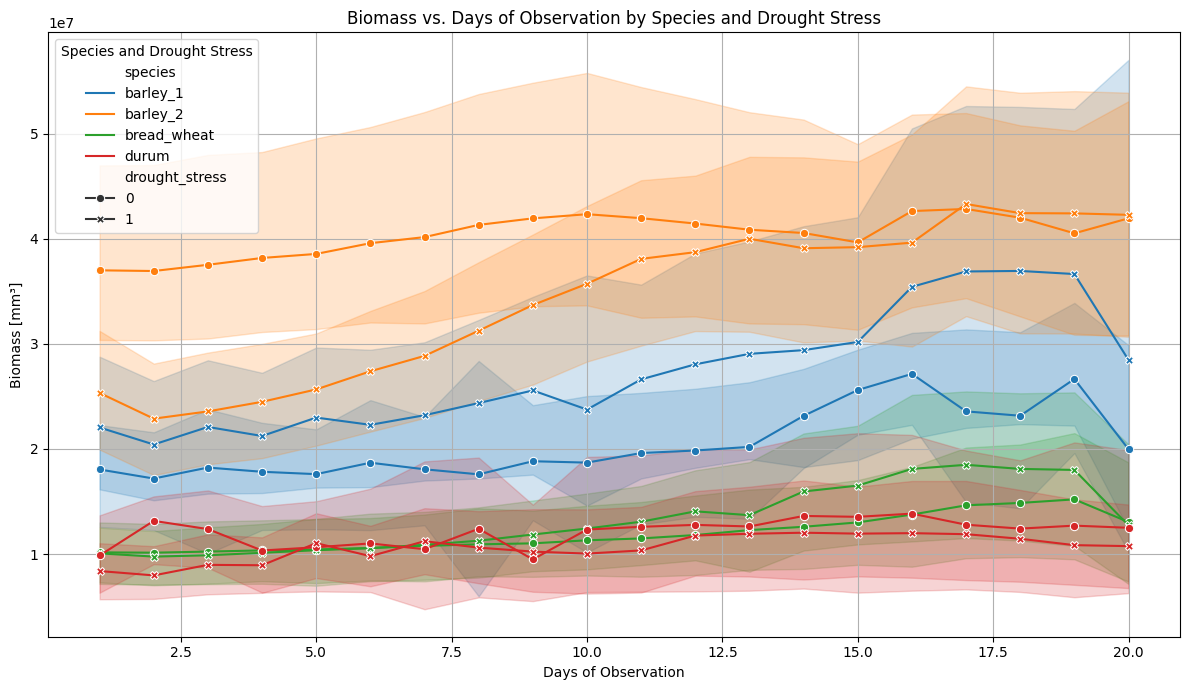

In [ ]:
# %% Plot digital biomass of each cultivar over days of phenotyping
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
sns.lineplot(
    data=df_loaded,
    x="days_of_phenotyping",
    y="digital_biomass",
    hue="species",
    style="drought_stress",
    markers=True,
    dashes=False,
)
plt.title("Biomass vs. Day of Phenotyping by Species and Drought Stress")
plt.xlabel("Day of Phenotyping")
plt.ylabel("Biomass [mm³]")
plt.legend(title="Species and Drought Stress")
plt.grid(True)
plt.tight_layout()
plt.show()

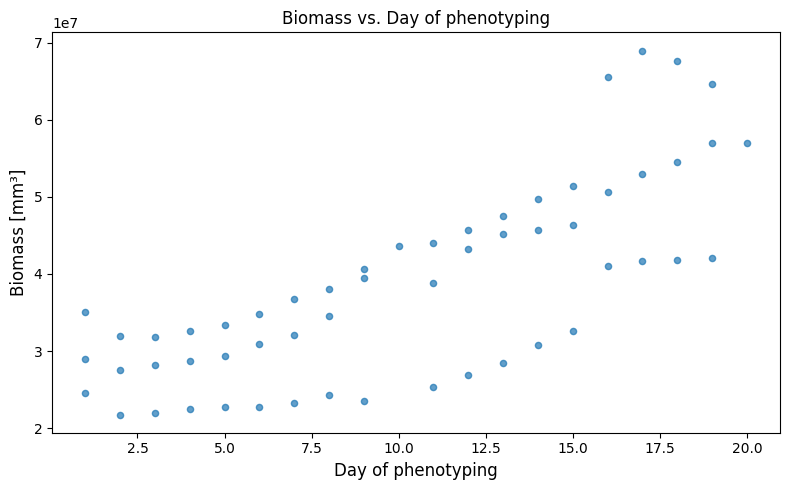

In [ ]:


# Diagram settings
title_font_size = 12
axis_font_size = 12

plt.figure(figsize=(8, 5))
ax = df_loaded[
    (df_loaded['species'] == "barley_1") & (df_loaded['nitrogen_applied'] == 130) & (df_loaded['drought_stress'] == 1)
].plot.scatter(
    x='days_of_phenotyping',
    y='digital_biomass',
    alpha=0.7,
    ax=plt.gca()
)
ax.set_xlabel('Day of phenotyping', fontsize=axis_font_size)
ax.set_ylabel('Biomass [mm³]', fontsize=axis_font_size)
ax.set_title('Biomass vs. Day of phenotyping', fontsize=title_font_size)
plt.tight_layout()
plt.show()

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from ipywidgets import interact, Dropdown, IntSlider, FloatSlider

# Load your dataset (replace with your actual data)
# Example: df = pd.read_csv("crop_yield.csv")
# For demo, let's create a synthetic dataset resembling your description
np.random.seed(42)
days = np.random.randint(1, 100, size=500)  # days_of_phenotyping
# non-linear biomass (logistic growth: slow start, rapid middle, slow end) + modest noise
L = 60        # asymptotic max biomass
k = 0.12      # growth rate
x0 = 35       # inflection (middle) day
biomass = L / (1 + np.exp(-k * (days - x0))) + np.abs(np.random.normal(0, 3, size=days.shape))

# Function to add outliers
def add_outliers(df, n_outliers):
    if n_outliers > 0:
        outlier_indices = np.random.choice(df.index, n_outliers, replace=False)
        noise = np.random.normal(0, 30, n_outliers)
        new_vals = df.loc[outlier_indices, "digital_biomass"] + noise
        # ensure biomass can't go negative
        new_vals = np.maximum(new_vals, 0)
        df.loc[outlier_indices, "digital_biomass"] = new_vals
    return df

# Function to split and visualize data
def visualize_splits(split_type, n_outliers, poly_degree):
    # df = df_loaded[(df_loaded['species'] == "barley_1") & (df_loaded['nitrogen_applied'] == 130) & (df_loaded['drought_stress'] == 1)]
    df = pd.DataFrame({"days_of_phenotyping": days, "digital_biomass": biomass})

    # Add outliers
    df = add_outliers(df.copy(), n_outliers)

    # Split data
    if split_type == "random":
        train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    else:  # stratified split by binning days_of_phenotyping
        bins = pd.cut(df["days_of_phenotyping"], bins=10)
        train_df, test_df = train_test_split(df, test_size=0.2, stratify=bins, random_state=42)

    # Plot histograms
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(df["days_of_phenotyping"], bins=10, alpha=0.5, label="Whole dataset")
    plt.hist(train_df["days_of_phenotyping"], bins=10, alpha=0.5, label="Train set")
    plt.hist(test_df["days_of_phenotyping"], bins=10, alpha=0.5, label="Test set")
    plt.title(f"Distribution of Days (Split: {split_type})")
    plt.xlabel("Days of Phenotyping")
    plt.ylabel("Frequency")
    plt.legend()

    # Train model
    X_train = train_df[["days_of_phenotyping"]].values
    y_train = train_df["digital_biomass"].values
    X_test = test_df[["days_of_phenotyping"]].values
    y_test = test_df["digital_biomass"].values

    # Polynomial regression pipeline
    model = Pipeline([
        ("poly", PolynomialFeatures(degree=poly_degree)),
        ("linear", LinearRegression())
    ])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Plot model fit (predictions as a line)
    plt.subplot(1, 2, 2)
    plt.scatter(X_train, y_train, color="sandybrown", label="Train data", alpha=0.5)
    plt.scatter(X_test, y_test, color="green", label="Test data", alpha=0.5)

    # Create a dense range of x values to plot a smooth prediction curve
    X_range = np.linspace(df["days_of_phenotyping"].min(), df["days_of_phenotyping"].max(), 300).reshape(-1, 1)
    y_line = model.predict(X_range)

    plt.plot(X_range, y_line, color="red", label="Predicted (line)", linewidth=2)
    plt.title(f"Polynomial Regression (Degree={poly_degree})\nMSE: {mse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")
    plt.xlabel("Days of Phenotyping")
    plt.ylabel("Digital Biomass")
    plt.ylim([-10, 100])
    plt.legend()
    plt.tight_layout()
    plt.show()

# Interactive widgets
interact(
    visualize_splits,
    split_type=Dropdown(description="Split Type:", options=["random", "stratified"], value="random"),
    n_outliers=IntSlider(description="Number of Outliers:", min=0, max=200, step=5, value=0),
    poly_degree=IntSlider(description="Polynomial Degree:", min=1, max=5, step=1, value=1)
)


interactive(children=(Dropdown(description='Split Type:', options=('random', 'stratified'), value='random'), I…

<function __main__.visualize_splits(split_type, n_outliers, poly_degree)>